# DB2 Data Migration Performance Using Latest DMBench Version

## 1. Data Loading and Concatenation

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import dalex as dx
import matplotlib.pyplot as plt
import yaml
import requests

Declairing all the tables that we use in the experiemtns.

In [2]:
tables = {
    'Table name': ["LINEITEM1", "GIGANTICORDERS", "ORDERS2", "ORDERS3", "ORDERS4", "ORDERS5", "ORDERS6", "ORDERS7", "ORDERS8", "ORDERS10", "ORDERSWIDE2"],
    'Data size(MB)': [674, 5477, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 275, 5337],
    'number of rows': [3894493, 45000000, 15000000, 15000000, 15000000, 15000000, 15000000, 15000000,  15000000, 1993416, 15000000],
    'number of columns': [16, 9, 9, 9, 9, 9, 9, 9, 9, 9, 27]
    }

tables_df = pd.DataFrame(tables)
tables_df.head()

,Table name,Data size(MB),number of rows,number of columns
0,LINEITEM1,674,3894493,16
1,GIGANTICORDERS,5477,45000000,9
2,ORDERS2,1825,15000000,9
3,ORDERS3,1825,15000000,9
4,ORDERS4,1825,15000000,9


The system configuation for the first 24 experiemnts.

In [3]:
source_machine_specs = {
    'RAM (GB)': [120],
    'CPU': [16],
    'Disk (GB)': [20],
    'External Disk (GB)': [576]
    }

source_machine_df = pd.DataFrame(source_machine_specs)
source_machine_df.head()

,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,120,16,20,576


In [4]:
# Function to extract numeric part from RAM string (e.g. "10g" -> 10)
def extract_ram_value(ram_str):
    return float(''.join(filter(str.isdigit, ram_str)))

The system configuration for the 9 experiemtns in version 2 experiments.

In [5]:
# List of URLs containing YAML files
urls = [
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp72/engine-docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp73/engine-docker-compose.yml"
]


# List to store the parsed CPU and memory information from each YAML
parsed_yaml_data = []

# Loop through each URL and fetch YAML content
for url in urls:
    try:
        # Fetch the content of the YAML file
        response = requests.get(url)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Parse YAML content
            yaml_content = yaml.safe_load(response.text)
            
            # Check if 'deploy' and resource limits are present, otherwise use source_machine_df values
            if 'deploy' in yaml_content['services']['web'] and 'resources' in yaml_content['services']['web']['deploy']:
                # Extract 'cpus' and 'memory' (ram) limits from YAML or use machine's full capacity
                cpus = yaml_content['services']['web']['deploy']['resources']['limits'].get('cpus', source_machine_df["CPU"].values[0])
                print(cpus)
                cpus = float(cpus) / source_machine_df["CPU"].values[0]

                ram = yaml_content['services']['web']['deploy']['resources']['limits'].get('memory', f'{source_machine_df["RAM (GB)"].values[0]}g')
                ram_value = extract_ram_value(ram)  # Extract only the numeric part
            else:
                # If 'deploy' or resource limits are missing, use the entire source_machine_df values
                cpus = source_machine_df["CPU"].values[0]  # Access the first value
                ram_value = source_machine_df["RAM (GB)"].values[0]  # Access the first value
            
            # Append the extracted information as a dictionary to the list
            parsed_yaml_data.append({'CPU': cpus, 'RAM (GB)': ram_value})
            print(f"Successfully fetched and parsed: {url}")
        else:
            print(f"Failed to fetch {url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error while fetching {url}: {e}")

yaml_df = pd.DataFrame(parsed_yaml_data)


# print("New DataFrame created from YAML content:")
# print(yaml_df)

Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp72/engine-docker-compose.yml
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp73/engine-docker-compose.yml


Importing the experiments.

In [6]:
# New DMBnech version experiments
v4_exp72_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp72/performanceBenchmark.csv')
v4_exp73_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp73/performanceBenchmark.csv')

In [7]:
# Default DMbench generated data
v4_exp72_performance_df.head()

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,attempt_number,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,ExperimentStatus
0,1,NO,testdb_testdb,dummy,5,False,1,1.733460e+09,83.917497,0.000000,0,3.989928,False
1,1,NO,testdb_testdb,dummy,5,False,2,1.733460e+09,2585.946424,2563.860949,0,3.616408,True
2,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4241.551197,4202.515368,0,19.404496,True
3,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,77.148819,0.000000,0,23.171770,False
4,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4088.963677,4056.377666,0,12.879379,True


Concatenating all the experiments

In [8]:
# Assuming `v4_performance_dfs` contains the list of dataframes and `yaml_df` contains the extracted CPU/RAM values
v4_performance_dfs = [v4_exp72_performance_df, v4_exp73_performance_df]

# Extract the Disk and External Disk values from `source_machine_df`
disk_value = source_machine_df['Disk (GB)'].values[0]
external_disk_value = source_machine_df['External Disk (GB)'].values[0]

# Loop over each DataFrame and the corresponding row from yaml_df
extended_dfs = []  # To store the extended DataFrames

for i, df in enumerate(v4_performance_dfs):
    # Get the corresponding row from yaml_df (i-th row)
    yaml_row = yaml_df.iloc[i]
    
    # Repeat the values of yaml_row for the number of rows in the respective performance DataFrame
    repeated_yaml_row = pd.DataFrame([yaml_row] * len(df), index=df.index)
    
    # Add the Disk and External Disk values to every row of the DataFrame
    repeated_yaml_row['Disk (GB)'] = disk_value
    repeated_yaml_row['External Disk (GB)'] = external_disk_value
    
    # Concatenate the repeated yaml_row with the current performance DataFrame
    extended_df = pd.concat([df, repeated_yaml_row], axis=1)
    
    # Add the extended DataFrame to the list
    extended_dfs.append(extended_df)

# Combine all the extended DataFrames into one
v4_performance_df = pd.concat(extended_dfs, ignore_index=True)


In [9]:
v4_performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,attempt_number,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,ExperimentStatus,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,NO,testdb_testdb,dummy,5,False,1,1.733460e+09,83.917497,0.000000,0,3.989928,False,16,120,20,576
1,1,NO,testdb_testdb,dummy,5,False,2,1.733460e+09,2585.946424,2563.860949,0,3.616408,True,16,120,20,576
2,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4241.551197,4202.515368,0,19.404496,True,16,120,20,576
3,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,77.148819,0.000000,0,23.171770,False,16,120,20,576
4,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4088.963677,4056.377666,0,12.879379,True,16,120,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,1,GZIP,testdb_testdb,dummy,5,False,2,1.733972e+09,3910.127887,3864.459046,0,6.420141,True,16,120,20,576
105,1,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,13325.849076,13279.255327,0,13.466374,True,16,120,20,576
106,2,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,13145.963463,13098.641573,0,16.031338,True,16,120,20,576
107,3,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,72.381530,0.000000,0,16.281786,False,16,120,20,576


In [10]:
v4_performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiment Number               109 non-null    int64  
 1   compress                        109 non-null    object 
 2   sourceDatabasetoTargetDatabase  109 non-null    object 
 3   tables                          109 non-null    object 
 4   maxStreams                      109 non-null    int64  
 5   binary                          109 non-null    bool   
 6   attempt_number                  109 non-null    int64  
 7   Experiment startTime            109 non-null    float64
 8   TotalExperimentTime             109 non-null    float64
 9   TotaltransferTime               109 non-null    float64
 10  totalPrecheckTime               109 non-null    int64  
 11  TotalClearTime                  109 non-null    float64
 12  ExperimentStatus                109 

## 2. Data Cleaning

### 2.1 Check for duplicate rows and remove them if any.

In [11]:
v4_performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiment Number               109 non-null    int64  
 1   compress                        109 non-null    object 
 2   sourceDatabasetoTargetDatabase  109 non-null    object 
 3   tables                          109 non-null    object 
 4   maxStreams                      109 non-null    int64  
 5   binary                          109 non-null    bool   
 6   attempt_number                  109 non-null    int64  
 7   Experiment startTime            109 non-null    float64
 8   TotalExperimentTime             109 non-null    float64
 9   TotaltransferTime               109 non-null    float64
 10  totalPrecheckTime               109 non-null    int64  
 11  TotalClearTime                  109 non-null    float64
 12  ExperimentStatus                109 

In [12]:
v4_performance_df.duplicated().sum()

0

In [13]:
v4_performance_df.drop_duplicates(inplace=True)

### 2.2 Handle the missing values

In [14]:
v4_performance_df.isna().sum()

Experiment Number                 0
compress                          0
sourceDatabasetoTargetDatabase    0
tables                            0
maxStreams                        0
binary                            0
attempt_number                    0
Experiment startTime              0
TotalExperimentTime               0
TotaltransferTime                 0
totalPrecheckTime                 0
TotalClearTime                    0
ExperimentStatus                  0
CPU                               0
RAM (GB)                          0
Disk (GB)                         0
External Disk (GB)                0
dtype: int64

In [15]:
v4_performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,attempt_number,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,ExperimentStatus,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,NO,testdb_testdb,dummy,5,False,1,1.733460e+09,83.917497,0.000000,0,3.989928,False,16,120,20,576
1,1,NO,testdb_testdb,dummy,5,False,2,1.733460e+09,2585.946424,2563.860949,0,3.616408,True,16,120,20,576
2,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4241.551197,4202.515368,0,19.404496,True,16,120,20,576
3,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,77.148819,0.000000,0,23.171770,False,16,120,20,576
4,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4088.963677,4056.377666,0,12.879379,True,16,120,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,1,GZIP,testdb_testdb,dummy,5,False,2,1.733972e+09,3910.127887,3864.459046,0,6.420141,True,16,120,20,576
105,1,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,13325.849076,13279.255327,0,13.466374,True,16,120,20,576
106,2,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,13145.963463,13098.641573,0,16.031338,True,16,120,20,576
107,3,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,72.381530,0.000000,0,16.281786,False,16,120,20,576


In [16]:
v4_performance_df = v4_performance_df.drop(v4_performance_df[v4_performance_df['TotaltransferTime'] == 0].index)
v4_performance_df = v4_performance_df.drop(v4_performance_df[v4_performance_df['ExperimentStatus'] == False].index)
v4_performance_df = v4_performance_df.drop(v4_performance_df[v4_performance_df['tables'] == 'dummy'].index)

In [17]:
v4_performance_df.reset_index(drop=True, inplace=True)

In [18]:
v4_performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiment Number               68 non-null     int64  
 1   compress                        68 non-null     object 
 2   sourceDatabasetoTargetDatabase  68 non-null     object 
 3   tables                          68 non-null     object 
 4   maxStreams                      68 non-null     int64  
 5   binary                          68 non-null     bool   
 6   attempt_number                  68 non-null     int64  
 7   Experiment startTime            68 non-null     float64
 8   TotalExperimentTime             68 non-null     float64
 9   TotaltransferTime               68 non-null     float64
 10  totalPrecheckTime               68 non-null     int64  
 11  TotalClearTime                  68 non-null     float64
 12  ExperimentStatus                68 non

In [19]:
v4_performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,attempt_number,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,ExperimentStatus,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4241.551197,4202.515368,0,19.404496,True,16,120,20,576
1,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4088.963677,4056.377666,0,12.879379,True,16,120,20,576
2,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,2,1.733460e+09,4613.900415,4580.327486,0,5.327899,True,16,120,20,576
3,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1,1.733484e+09,3673.291009,3644.815263,0,9.033586,True,16,120,20,576
4,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1,1.733484e+09,4214.793291,4180.310610,0,14.321725,True,16,120,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,1,GZIP,testdb_testdb,ORDERS2_ORDERS10,5,True,1,1.733880e+09,3134.608567,3106.228109,0,14.296616,True,16,120,20,576
64,2,GZIP,testdb_testdb,ORDERS2_ORDERS10,5,True,1,1.733880e+09,3324.654910,3298.589495,0,9.794496,True,16,120,20,576
65,3,GZIP,testdb_testdb,ORDERS2_ORDERS10,5,True,1,1.733880e+09,3209.209934,3186.462559,0,9.881012,True,16,120,20,576
66,1,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,13325.849076,13279.255327,0,13.466374,True,16,120,20,576


## 3. Feature Engineering

Function `calculate_table_sums` calculates and aggregates the total data size, number of rows, and number of columns for specified table names within the DataFrame.

In [20]:
def calculate_table_sums(exp_df, tables_df):

    # Extract table names
    table_names_series = exp_df['tables'].str.split('_', expand=False)
    
    # Initialize lists to store the sums
    data_size_sum = []
    rows_sum = []
    columns_sum = []
    print(data_size_sum, rows_sum, columns_sum)

    # Iterate over each row of table names
    for table_names in table_names_series:
        # Filter the info dataframe for the current table names
        filtered_info = tables_df[tables_df['Table name'].isin(table_names)]
        # print(filtered_info)
        # Calculate the sums
        data_size_sum.append(filtered_info['Data size(MB)'].sum())
        rows_sum.append(filtered_info['number of rows'].sum())
        columns_sum.append(filtered_info['number of columns'].sum())
        # print(data_size_sum, rows_sum, columns_sum)


    # Add the sums as new features in the initial dataframe
    exp_df['Data size sum (MB)'] = data_size_sum
    exp_df['Number of rows sum'] = rows_sum
    exp_df['Number of columns sum'] = columns_sum

    
    # exp_df = exp_df[['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase', 'tables', 'Data size sum (MB)', 
    #                  'Number of rows sum', 'Number of columns sum', 'maxStreams', 'binary', 'Experiment startTime', 
    #                  'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime', 'TotalClearTime', 'RAM (GB)',	'CPU', 'Disk (GB)', 'External Disk (GB)']]

    return exp_df

In [21]:
result_df = calculate_table_sums(v4_performance_df, tables_df)

[] [] []


In [22]:
result_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,attempt_number,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,ExperimentStatus,CPU,RAM (GB),Disk (GB),External Disk (GB),Data size sum (MB),Number of rows sum,Number of columns sum
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4241.551197,4202.515368,0,19.404496,True,16,120,20,576,2774,20887909,34
1,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.733460e+09,4088.963677,4056.377666,0,12.879379,True,16,120,20,576,2774,20887909,34
2,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,2,1.733460e+09,4613.900415,4580.327486,0,5.327899,True,16,120,20,576,2774,20887909,34
3,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1,1.733484e+09,3673.291009,3644.815263,0,9.033586,True,16,120,20,576,2774,20887909,34
4,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1,1.733484e+09,4214.793291,4180.310610,0,14.321725,True,16,120,20,576,2774,20887909,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,1,GZIP,testdb_testdb,ORDERS2_ORDERS10,5,True,1,1.733880e+09,3134.608567,3106.228109,0,14.296616,True,16,120,20,576,2100,16993416,18
64,2,GZIP,testdb_testdb,ORDERS2_ORDERS10,5,True,1,1.733880e+09,3324.654910,3298.589495,0,9.794496,True,16,120,20,576,2100,16993416,18
65,3,GZIP,testdb_testdb,ORDERS2_ORDERS10,5,True,1,1.733880e+09,3209.209934,3186.462559,0,9.881012,True,16,120,20,576,2100,16993416,18
66,1,GZIP,testdb_testdb,ORDERSWIDE2,5,False,1,1.733972e+09,13325.849076,13279.255327,0,13.466374,True,16,120,20,576,5337,15000000,27


In [23]:
result_df.drop(labels=['Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables', 
                            'attempt_number', 'TotalExperimentTime', 'totalPrecheckTime',  
                            'ExperimentStatus', 'TotalClearTime', 'Experiment startTime'], axis=1, inplace=True)

In [24]:
result_df.head()

,compress,maxStreams,binary,TotaltransferTime,CPU,RAM (GB),Disk (GB),External Disk (GB),Data size sum (MB),Number of rows sum,Number of columns sum
0,NO,5,False,4202.515368,16,120,20,576,2774,20887909,34
1,NO,5,False,4056.377666,16,120,20,576,2774,20887909,34
2,NO,5,False,4580.327486,16,120,20,576,2774,20887909,34
3,NO,5,True,3644.815263,16,120,20,576,2774,20887909,34
4,NO,5,True,4180.310610,16,120,20,576,2774,20887909,34


In [25]:
print(result_df.columns)

Index(['compress', 'maxStreams', 'binary', 'TotaltransferTime', 'CPU',
       'RAM (GB)', 'Disk (GB)', 'External Disk (GB)', 'Data size sum (MB)',
       'Number of rows sum', 'Number of columns sum'],
      dtype='object')


In [26]:
# Reordering the features
result_df = result_df[['compress', 'maxStreams', 'binary', 
       'CPU', 'RAM (GB)', 'Disk (GB)',
       'External Disk (GB)', 'Data size sum (MB)', 'Number of rows sum',
       'Number of columns sum', 'TotaltransferTime']]

## 4. Data Visualization Preprocessing

### 4.1 Correlation Matrix using Pearson correlation coefficient

In [27]:
result_df.describe()

,maxStreams,CPU,RAM (GB),Disk (GB),External Disk (GB),Data size sum (MB),Number of rows sum,Number of columns sum,TotaltransferTime
count,68.0,68.0,68.0,68.0,68.0,68.000000,6.800000e+01,68.000000,68.000000
mean,5.0,16.0,120.0,20.0,576.0,2567.382353,1.414654e+07,23.558824,4110.956731
std,0.0,0.0,0.0,0.0,0.0,1623.611030,6.540336e+06,7.444085,2957.984057
min,5.0,16.0,120.0,20.0,576.0,674.000000,3.894493e+06,16.000000,1136.475105
25%,5.0,16.0,120.0,20.0,576.0,674.000000,3.894493e+06,16.000000,1286.620007
50%,5.0,16.0,120.0,20.0,576.0,2100.000000,1.699342e+07,18.000000,3435.349669
75%,5.0,16.0,120.0,20.0,576.0,2774.000000,2.088791e+07,34.000000,4185.861800
max,5.0,16.0,120.0,20.0,576.0,5337.000000,2.088791e+07,34.000000,13279.255327


In [28]:
# Calculate the correlation matrix
corr_matrix = result_df.corr(numeric_only=True)
corr_matrix

,maxStreams,binary,CPU,RAM (GB),Disk (GB),External Disk (GB),Data size sum (MB),Number of rows sum,Number of columns sum,TotaltransferTime
maxStreams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
binary,NaN,1.000000,NaN,NaN,NaN,NaN,-0.050567,-0.003868,-0.013703,-0.096111
CPU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RAM (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
External Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Data size sum (MB),NaN,-0.050567,NaN,NaN,NaN,NaN,1.000000,0.539183,0.588602,0.941179
Number of rows sum,NaN,-0.003868,NaN,NaN,NaN,NaN,0.539183,1.000000,0.741297,0.405917
Number of columns sum,NaN,-0.013703,NaN,NaN,NaN,NaN,0.588602,0.741297,1.000000,0.466705
TotaltransferTime,NaN,-0.096111,NaN,NaN,NaN,NaN,0.941179,0.405917,0.466705,1.000000


### 4.2 Correlation with regard to the target "Total Transfer Time"

In [29]:
corr_matrix["TotaltransferTime"].sort_values(ascending=False)

TotaltransferTime        1.000000
Data size sum (MB)       0.941179
Number of columns sum    0.466705
Number of rows sum       0.405917
binary                  -0.096111
maxStreams                    NaN
CPU                           NaN
RAM (GB)                      NaN
Disk (GB)                     NaN
External Disk (GB)            NaN
Name: TotaltransferTime, dtype: float64

### 4.3 Histogram

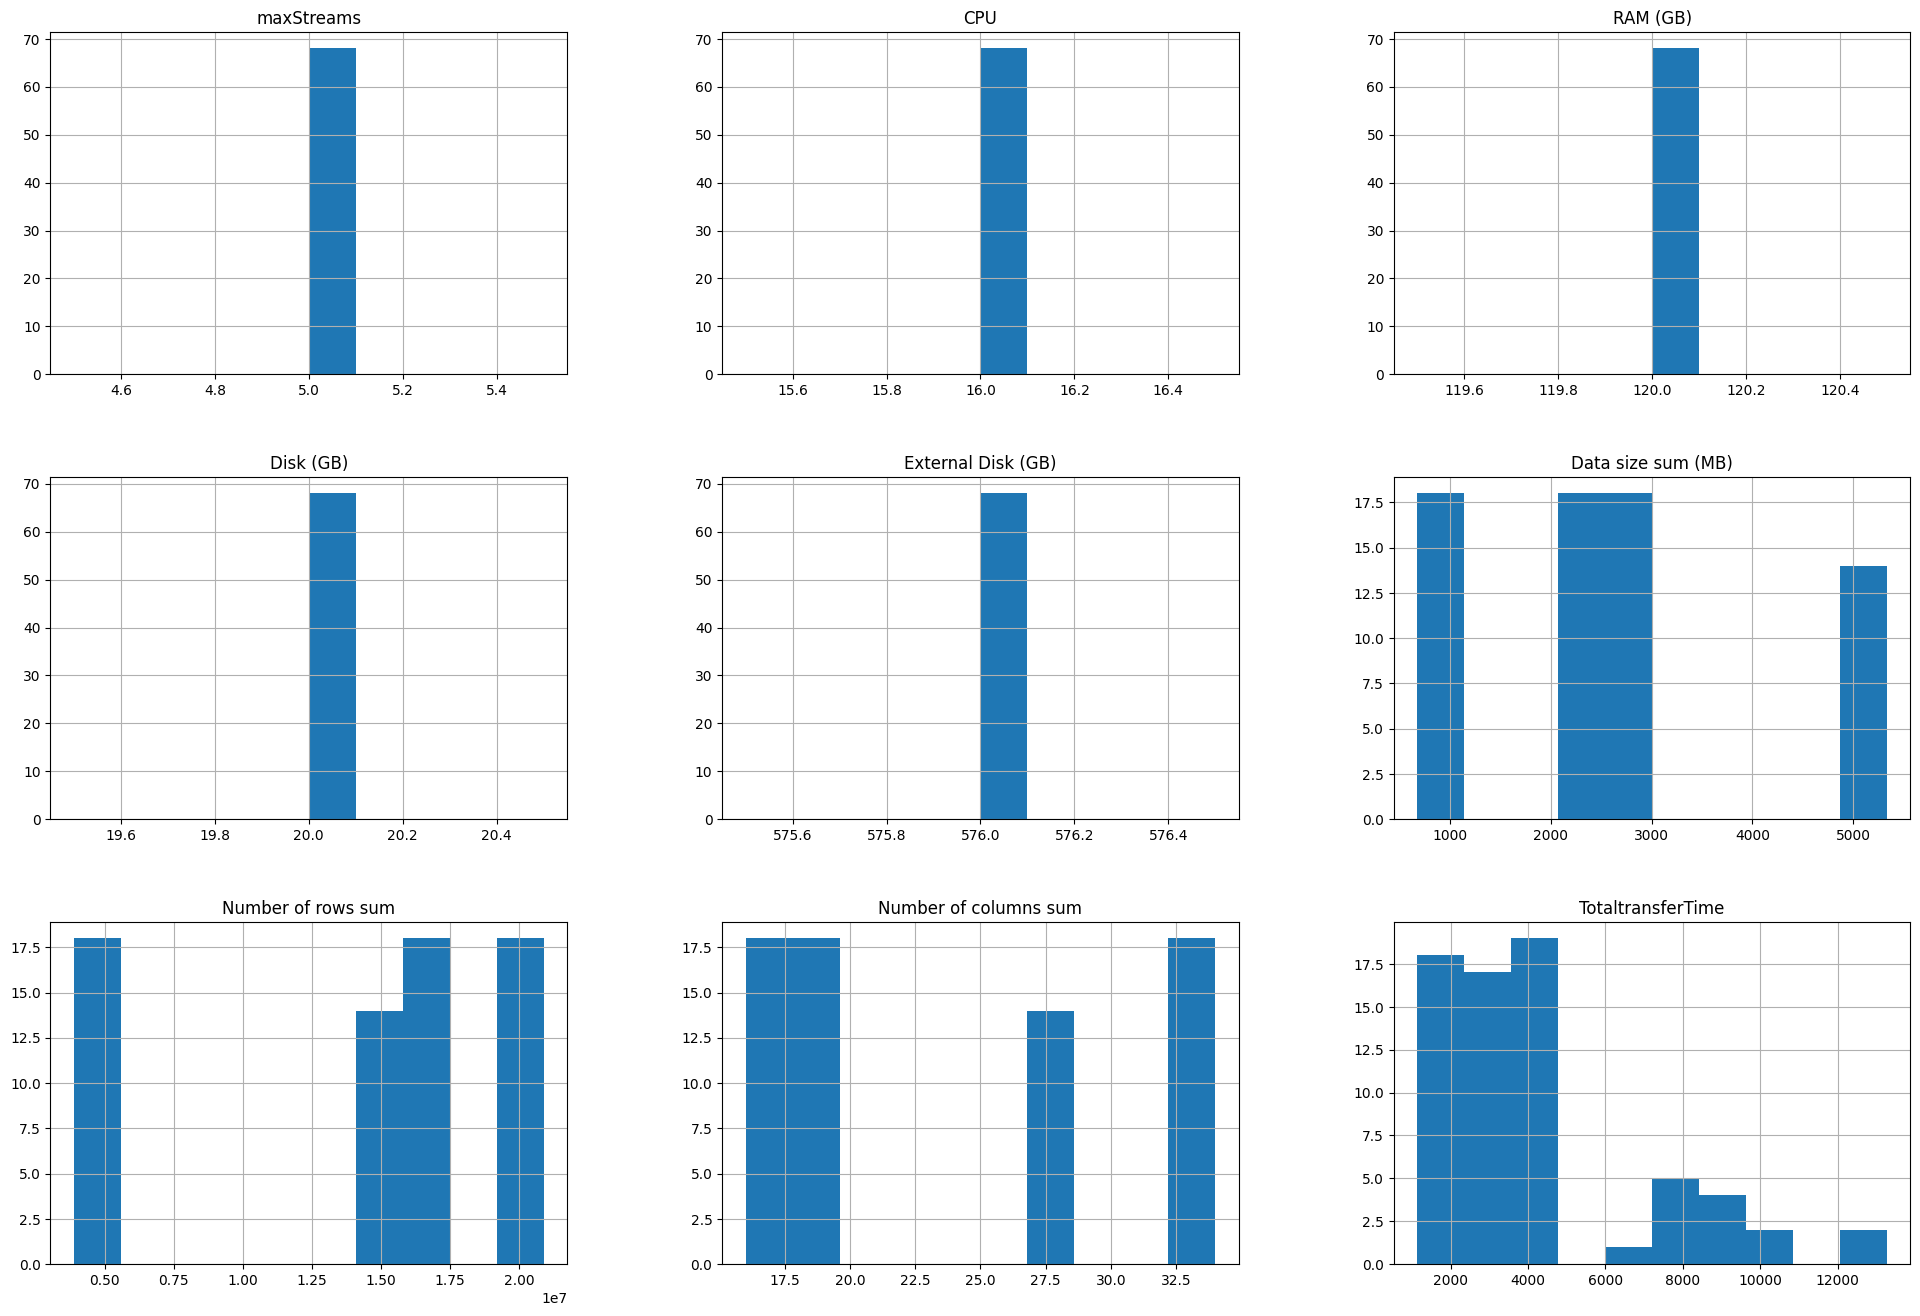

In [30]:
result_df.hist(figsize=(24, 16))
plt.show()

## 5. Preprocessing

### 5.1 Create a pipeline

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [32]:
# Separate numerical and categorical columns
num_cols = result_df.select_dtypes(include='number').columns.to_list()
cat_cols = result_df.select_dtypes(exclude='number').columns.to_list()

# Exclude the target from numerical columns
num_cols.remove("TotaltransferTime")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Use ColumnTransformer to set the estimators and transformations
preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [33]:
# Display the pipeline
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['maxStreams', 'CPU', 'RAM (GB)', 'Disk (GB)',
                                  'External Disk (GB)', 'Data size sum (MB)',
                                  'Number of rows sum',
                                  'Number of columns sum']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['compress', 'binary'])])

In [34]:
for col in cat_cols:
    print(f"{col}: {result_df[col].unique()}")


compress: ['NO' 'LZ4' 'GZIP']
binary: [False  True]


In [35]:
# Apply the preprocessing pipeline on the dataset
result_df_prepared = preprocessing.fit_transform(result_df)

# Scikit-learn strips the column headers, so just add them back on afterward.
feature_names = preprocessing.get_feature_names_out()
result_df_prepared = pd.DataFrame(data=result_df_prepared, columns=feature_names)

result_df_prepared

,num__maxStreams,num__CPU,num__RAM (GB),num__Disk (GB),num__External Disk (GB),num__Data size sum (MB),num__Number of rows sum,num__Number of columns sum,cat__compress_GZIP,cat__compress_LZ4,cat__compress_NO,cat__binary_False,cat__binary_True,remainder__TotaltransferTime
0,0.0,0.0,0.0,0.0,0.0,0.128204,1.038401,1.413042,0.0,0.0,1.0,1.0,0.0,4202.515368
1,0.0,0.0,0.0,0.0,0.0,0.128204,1.038401,1.413042,0.0,0.0,1.0,1.0,0.0,4056.377666
2,0.0,0.0,0.0,0.0,0.0,0.128204,1.038401,1.413042,0.0,0.0,1.0,1.0,0.0,4580.327486
3,0.0,0.0,0.0,0.0,0.0,0.128204,1.038401,1.413042,0.0,0.0,1.0,0.0,1.0,3644.815263
4,0.0,0.0,0.0,0.0,0.0,0.128204,1.038401,1.413042,0.0,0.0,1.0,0.0,1.0,4180.310610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.0,0.0,0.0,0.0,0.0,-0.290006,0.438516,-0.752296,1.0,0.0,0.0,0.0,1.0,3106.228109
64,0.0,0.0,0.0,0.0,0.0,-0.290006,0.438516,-0.752296,1.0,0.0,0.0,0.0,1.0,3298.589495
65,0.0,0.0,0.0,0.0,0.0,-0.290006,0.438516,-0.752296,1.0,0.0,0.0,0.0,1.0,3186.462559
66,0.0,0.0,0.0,0.0,0.0,1.718521,0.131462,0.465707,1.0,0.0,0.0,1.0,0.0,13279.255327


## 6. Model Selection and Training

### 6.1 Keeping the Whole Dataset as the Training Set

In [36]:
from sklearn.model_selection import train_test_split

# Splitting data into features and target variable
X = result_df_prepared.drop(["remainder__TotaltransferTime"], axis=1)
y = result_df_prepared["remainder__TotaltransferTime"]

# # Splitting into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [37]:
# Decision Tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

### 6.2 Statistical Validation 

Cross Validation Over K Folds for Models with Default Parameters

In [38]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Define custom scoring functions
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Create custom scorers
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer = make_scorer(mae, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# List of models to evaluate
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "Linear Regression": LinearRegression()
}

# Set up cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize a dictionary to store results
cv_results = {metric: {} for metric in ["RMSE", "MAE", "MSE", "R2"]}
rmse_dict = {name: [] for name in models.keys()}  # Store all RMSE values for normality testing

# Perform cross-validation for each model
for name, model in models.items():
    rmse_scores = -cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)  # 10 RMSE values
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

    # Store all RMSE values in rmse_dict
    rmse_dict[name] = rmse_scores.tolist()

    # Store mean and standard deviation of each metric
    cv_results["RMSE"][name] = {"Mean": np.mean(rmse_scores) / 60, "STD": np.std(rmse_scores) / 60}
    cv_results["MAE"][name] = {"Mean": np.mean(mae_scores) / 60, "STD": np.std(mae_scores) / 60}
    cv_results["MSE"][name] = {"Mean": np.mean(-mse_scores) / 60, "STD": np.std(-mse_scores) / 60}
    cv_results["R2"][name] = {"Mean": np.mean(r2_scores), "STD": np.std(r2_scores)}

# Convert results to DataFrame for summary report
summary_df = pd.DataFrame({
    "RMSE Mean (min)": [cv_results["RMSE"][name]["Mean"] for name in models.keys()],
    "RMSE STD (min)": [cv_results["RMSE"][name]["STD"] for name in models.keys()],
    "MAE Mean (min)": [cv_results["MAE"][name]["Mean"] for name in models.keys()],
    "MAE STD (min)": [cv_results["MAE"][name]["STD"] for name in models.keys()],
    "MSE Mean (min)": [cv_results["MSE"][name]["Mean"] for name in models.keys()],
    "MSE STD (min)": [cv_results["MSE"][name]["STD"] for name in models.keys()],
    "R2 Mean": [cv_results["R2"][name]["Mean"] for name in models.keys()],
    "R2 STD": [cv_results["R2"][name]["STD"] for name in models.keys()]
}, index=models.keys())

# Display summary
print("\nSummary of Model Evaluation Results:")
summary_df



Summary of Model Evaluation Results:


,RMSE Mean (min),RMSE STD (min),MAE Mean (min),MAE STD (min),MSE Mean (min),MSE STD (min),R2 Mean,R2 STD
Decision Tree,7.280139,7.797722,4.792755,4.126022,-6828.293997,16000.482840,0.971692,0.042258
Random Forest,7.935309,10.289924,5.159367,5.576672,-10131.099930,26157.431281,0.962904,0.070668
Gradient Boosting,7.836471,9.706811,5.097321,5.276691,-9337.947533,23635.238983,0.964484,0.063537
XGBoost,9.345100,13.922885,5.897250,7.393985,-16870.657429,46105.752733,0.943583,0.126163
Linear Regression,15.096138,10.342211,11.533888,6.628738,-20091.282721,30827.557863,0.866950,0.109014


Shapiro-Wilk test:

In [39]:
from scipy.stats import shapiro

# Shapiro-Wilk test for each model's RMSE values
for model_name, rmse_values in rmse_dict.items():
    stat, p_value = shapiro(rmse_values)
    print(f"{model_name}: Shapiro-Wilk test statistic = {stat:.4f}, p-value = {p_value:.4f}")
    
    if p_value > 0.05:
        print(f"The RMSE values for {model_name} are approximately normally distributed.")
    else:
        print(f"The RMSE values for {model_name} are not normally distributed.")


Decision Tree: Shapiro-Wilk test statistic = 0.5441, p-value = 0.0000
The RMSE values for Decision Tree are not normally distributed.
Random Forest: Shapiro-Wilk test statistic = 0.5118, p-value = 0.0000
The RMSE values for Random Forest are not normally distributed.
Gradient Boosting: Shapiro-Wilk test statistic = 0.5187, p-value = 0.0000
The RMSE values for Gradient Boosting are not normally distributed.
XGBoost: Shapiro-Wilk test statistic = 0.4654, p-value = 0.0000
The RMSE values for XGBoost are not normally distributed.
Linear Regression: Shapiro-Wilk test statistic = 0.7512, p-value = 0.0037
The RMSE values for Linear Regression are not normally distributed.


Friedman Test

In [40]:
from scipy.stats import friedmanchisquare

# Collect RMSE scores for each model
rmse_scores_list = [cv_results["RMSE"][name]["Mean"] * 60 for name in models.keys()]  # Convert back from minutes

# Perform Friedman test
stat, p = friedmanchisquare(*rmse_scores_list)

# Print results
print(f"Friedman Test Statistic: {stat:.4f}, p-value: {p:.4f}")

# Interpretation
if p < 0.05:
    print("Significant differences found among models. Proceed with post-hoc tests.")
else:
    print("No significant differences found among models.")


Friedman Test Statistic: 4.0000, p-value: 0.4060
No significant differences found among models.


Kruskal-Wallis Test

In [41]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test
stat, p = kruskal(*rmse_scores_list)

# Print results
print(f"Kruskal-Wallis Test Statistic: {stat:.4f}, p-value: {p:.4f}")

# Interpretation
if p < 0.05:
    print("Significant differences found among models. Proceed with pairwise Wilcoxon tests.")
else:
    print("No significant differences found among models.")


Kruskal-Wallis Test Statistic: 4.0000, p-value: 0.4060
No significant differences found among models.


Default Models Performance Report

In [42]:
# Function to generate regression reports
def regression_report(model, X_train, y_train):
    # Split X_train and y_train to create a validation set
    X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Train on the train part
    model.fit(X_train_part, y_train_part)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)  # Mean Absolute Error
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))  # Root Mean Squared Error
    r2 = r2_score(y_val, y_pred)  # R² Score

    return mae, rmse_val, r2  # Return only MAE, RMSE, and R²

In [43]:
# Define feature importance function
def plot_feature_importance(model, X, title):
    # Plot feature importance
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    features = np.array(X.columns)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(X.shape[1]), importance[indices], align='center')
    plt.xticks(range(X.shape[1]), features[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.show()

In [44]:
# Initialize a dictionary to store reports and RMSE scores
reports = {}
metrics_scores = {}

### 6.3 Two Top Models Training and Hyperparameter Tuning

In [45]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

# Function to generate regression reports using cross-validation
def regression_report(model, X, y, cv=5):
    """
    Evaluates a regression model using cross-validation and returns MAE, RMSE, and R².
    """
    mae = -np.mean(cross_val_score(model, X, y, cv=cv, scoring="neg_mean_absolute_error"))
    rmse_val = np.sqrt(-np.mean(cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")))
    r2 = np.mean(cross_val_score(model, X, y, cv=cv, scoring="r2"))

    return mae, rmse_val, r2



In [46]:
# Function to plot feature importance for tree-based models
def plot_feature_importance(model, X, title):
    """
    Plots feature importance for tree-based models.
    """
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
        features = np.array(X.columns)
        
        plt.figure(figsize=(10, 6))
        plt.title(title)
        plt.bar(range(X.shape[1]), importance[indices], align='center')
        plt.xticks(range(X.shape[1]), features[indices], rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature importance not available for {title}")

In [47]:
# Automatically select the top 2 models based on lowest RMSE
top_models = summary_df.sort_values(by="RMSE Mean (min)").index[:2].tolist()
print(f"\nTop 2 Performing Models (Based on RMSE): {top_models}\n")


Top 2 Performing Models (Based on RMSE): ['Decision Tree', 'Gradient Boosting']



In [48]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Dictionary to store hyperparameter tuning results
tuning_results = {}
best_models = {}  # Dictionary to store best models

# Hyperparameter tuning for the top 2 models
for model_name in top_models:
    print(f"\n Hyperparameter Tuning for {model_name}...\n")

    # Initialize the base model
    if model_name == "Decision Tree":
        base_model = DecisionTreeRegressor(random_state=42)
        param_dist = {
            "max_depth": randint(3, 20),
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 20)
        }
        param_grid = {
            "max_depth": [3, 5, 10, 15, 20],
            "min_samples_split": [2, 5, 10, 15, 20],
            "min_samples_leaf": [1, 2, 5, 10, 15]
        }
    
    elif model_name == "Random Forest":
        base_model = RandomForestRegressor(random_state=42)
        param_dist = {
            "n_estimators": randint(50, 300),
            "max_depth": randint(3, 20),
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 20)
        }
        param_grid = {
            "n_estimators": [50, 100, 200, 300],
            "max_depth": [3, 5, 10, 15, 20],
            "min_samples_split": [2, 5, 10, 15, 20],
            "min_samples_leaf": [1, 2, 5, 10, 15]
        }
    
    elif model_name == "Gradient Boosting":
        base_model = GradientBoostingRegressor(random_state=42)
        param_dist = {
            "n_estimators": randint(50, 300),
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": randint(3, 15)
        }
        param_grid = {
            "n_estimators": [50, 100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 5, 10, 15]
        }
    
    elif model_name == "XGBoost":
        base_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
        param_dist = {
            "n_estimators": randint(50, 300),
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": randint(3, 15)
        }
        param_grid = {
            "n_estimators": [50, 100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 5, 10, 15]
        }

    # Store default model performance
    tuning_results[f"{model_name} (Default)"] = regression_report(base_model, X, y)
    best_models[f"{model_name} (Default)"] = base_model  # Store the default model

    # Random Search Hyperparameter Tuning
    random_search = RandomizedSearchCV(base_model, param_distributions=param_dist, 
                                       n_iter=50, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X, y)
    best_models[f"{model_name} (Random Search)"] = random_search.best_estimator_

    tuning_results[f"{model_name} (Random Search)"] = regression_report(best_models[f"{model_name} (Random Search)"], X, y)

    # Grid Search Hyperparameter Tuning
    grid_search = GridSearchCV(base_model, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    best_models[f"{model_name} (Grid Search)"] = grid_search.best_estimator_

    tuning_results[f"{model_name} (Grid Search)"] = regression_report(best_models[f"{model_name} (Grid Search)"], X, y)

# Convert tuning results into a DataFrame for comparison
tuning_df = pd.DataFrame(tuning_results, index=["MAE", "RMSE", "R²"]).T
tuning_df = tuning_df.reset_index().rename(columns={'index': 'Model'})

# Display final tuning results
print("\nHyperparameter Tuning Results:")
print(tuning_df.to_string())

tuning_df[['MAE', 'RMSE']] /= 60
tuning_df.sort_values('RMSE')



 Hyperparameter Tuning for Decision Tree...


 Hyperparameter Tuning for Gradient Boosting...


Hyperparameter Tuning Results:
                               Model         MAE         RMSE        R²
0            Decision Tree (Default)  817.288061  1626.622023  0.689124
1      Decision Tree (Random Search)  643.542431  1185.122170  0.786938
2        Decision Tree (Grid Search)  636.025286  1184.475782  0.787444
3        Gradient Boosting (Default)  686.818842  1463.531096  0.585635
4  Gradient Boosting (Random Search)  566.658980  1162.860869  0.765263
5    Gradient Boosting (Grid Search)  566.637142  1162.834754  0.765282


,Model,MAE,RMSE,R²
5,Gradient Boosting (Grid Search),9.443952,19.380579,0.765282
4,Gradient Boosting (Random Search),9.444316,19.381014,0.765263
2,Decision Tree (Grid Search),10.600421,19.741263,0.787444
1,Decision Tree (Random Search),10.725707,19.752036,0.786938
3,Gradient Boosting (Default),11.446981,24.392185,0.585635
0,Decision Tree (Default),13.621468,27.110367,0.689124


## 7. Visualizing the Performance

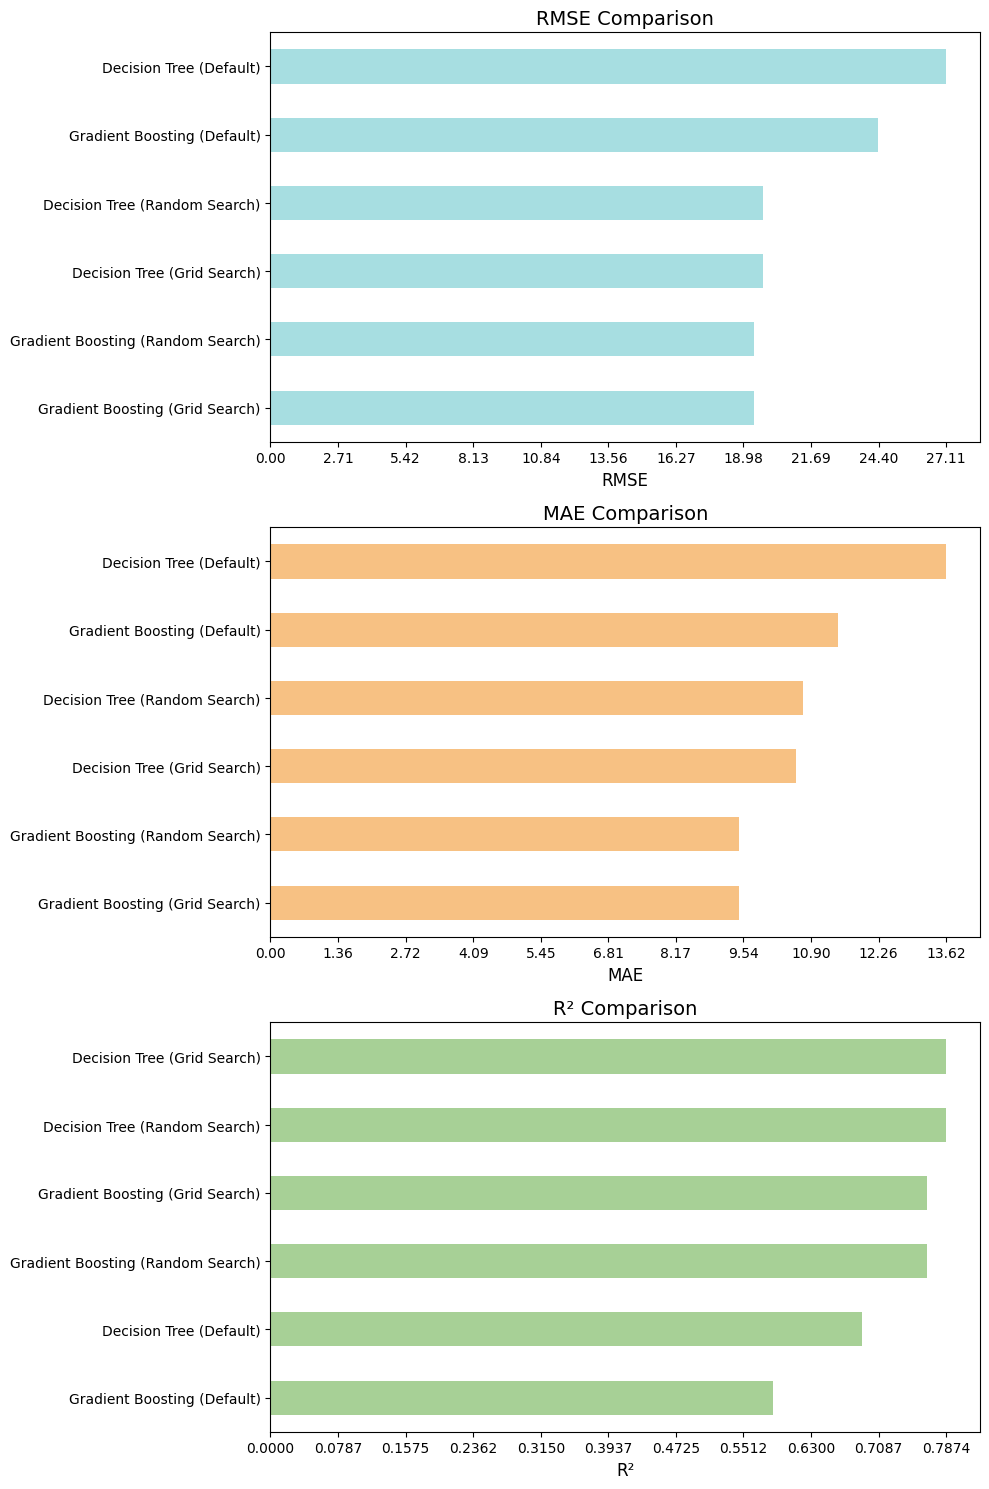

In [49]:
# Define colors for each metric
colors = {
    'RMSE': '#a7dee1',  # RMSE in blue
    'MAE': '#f7c183',   # MAE in orange
    'R²': '#a7d096'     # R2 in green
}

# Define the metrics
metrics = ['RMSE', 'MAE', 'R²']
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=False)

# Loop over each metric and customize each subplot
for i, metric in enumerate(metrics):
    tuning_df.sort_values(by=metric).plot(kind='barh', x='Model', y=metric, ax=axes[i], color=colors[metric], legend=False)
    axes[i].set_title(f'{metric} Comparison', fontsize=14)
    axes[i].set_xlabel(metric, fontsize=12)
    axes[i].set_ylabel('')

    # Adjust x-axis to show floating-point numbers
    max_value = tuning_df[metric].max()
    step_size = max_value / 10  # Define a step size relative to the maximum value
    axes[i].set_xticks(np.arange(0, max_value + step_size, step_size))
    axes[i].tick_params(axis='x', which='both', labelsize=10)

plt.tight_layout()
plt.show()

### 7.1 Feature Importances

Visualize the feature importances for each model.

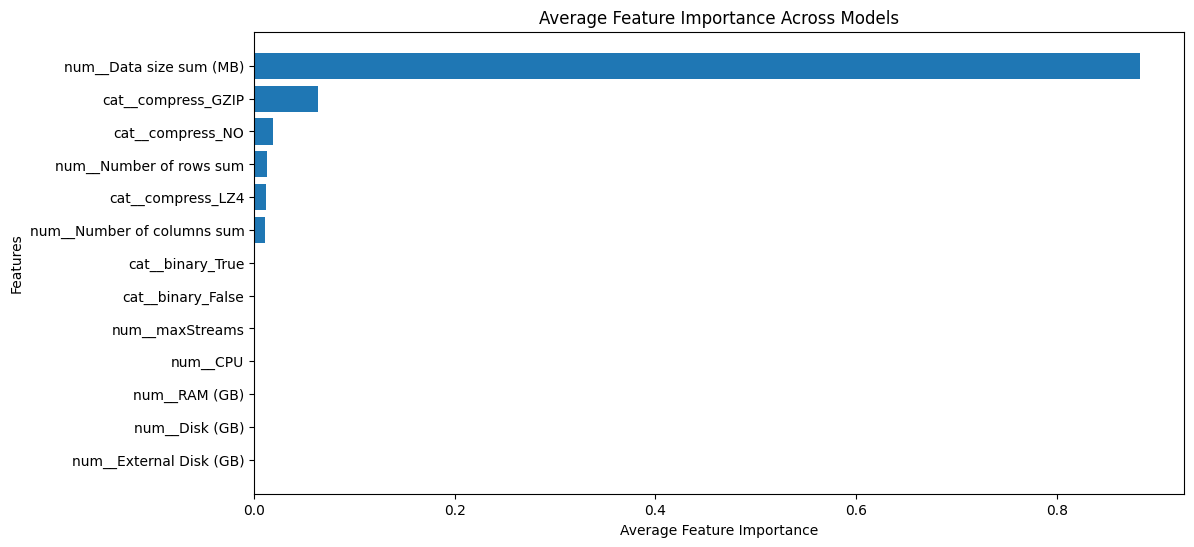

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dictionary to store feature importances
feature_importances = {col: [] for col in X.columns}

# Select only tree-based models for feature importance analysis
tree_models = [name for name in best_models.keys() if "Linear Regression" not in name]

# Collect feature importance scores from all tree-based models
for model_name in tree_models:
    model = best_models[model_name]
    if hasattr(model, "feature_importances_"):  # Ensure the model supports feature importance
        for col, importance in zip(X.columns, model.feature_importances_):
            feature_importances[col].append(importance)

# Compute average feature importance across all six models
average_importance = {col: np.mean(values) if values else 0 for col, values in feature_importances.items()}

# Convert to DataFrame for visualization
importance_df = pd.DataFrame.from_dict(average_importance, orient="index", columns=["Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df.index, importance_df["Importance"])
plt.xlabel("Average Feature Importance")
plt.ylabel("Features")
plt.title("Average Feature Importance Across Models")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [51]:
# Identify the best performing model for each of the top 2 models
best_model_1 = tuning_df[tuning_df["Model"].str.contains(top_models[0])].sort_values("RMSE").iloc[0]["Model"]
best_model_2 = tuning_df[tuning_df["Model"].str.contains(top_models[1])].sort_values("RMSE").iloc[0]["Model"]

# Retrieve the actual model objects from best_models dictionary
top_model_1 = best_models[best_model_1]
top_model_2 = best_models[best_model_2]

print(f"Best performing model for {top_models[0]}: {best_model_1}")
print(f"Best performing model for {top_models[1]}: {best_model_2}")


Best performing model for Decision Tree: Decision Tree (Grid Search)
Best performing model for Gradient Boosting: Gradient Boosting (Grid Search)


SHAP Analysis

c:\Users\hasti\anaconda3\envs\DMBenchML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Running SHAP Analysis for Decision Tree (Grid Search) (DecisionTreeRegressor)...



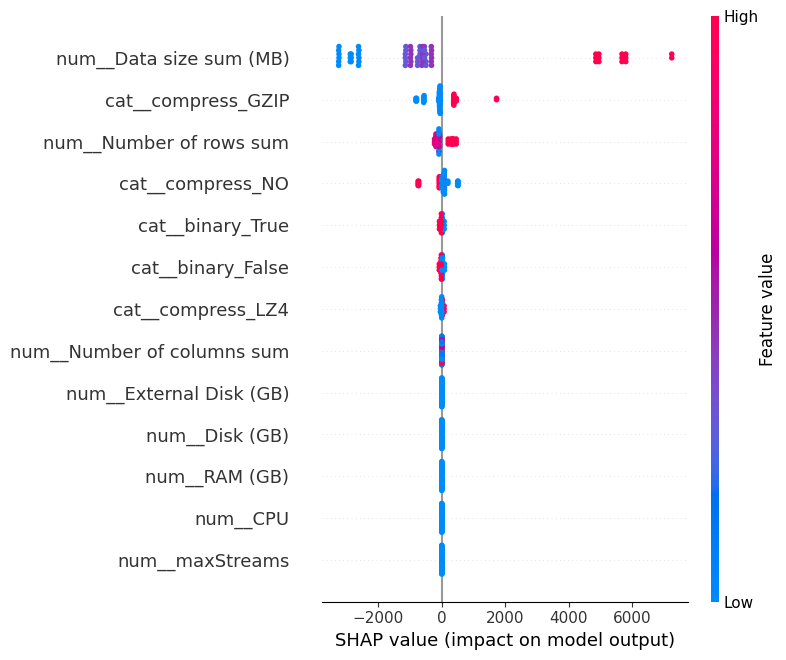


Running SHAP Analysis for Gradient Boosting (Grid Search) (GradientBoostingRegressor)...



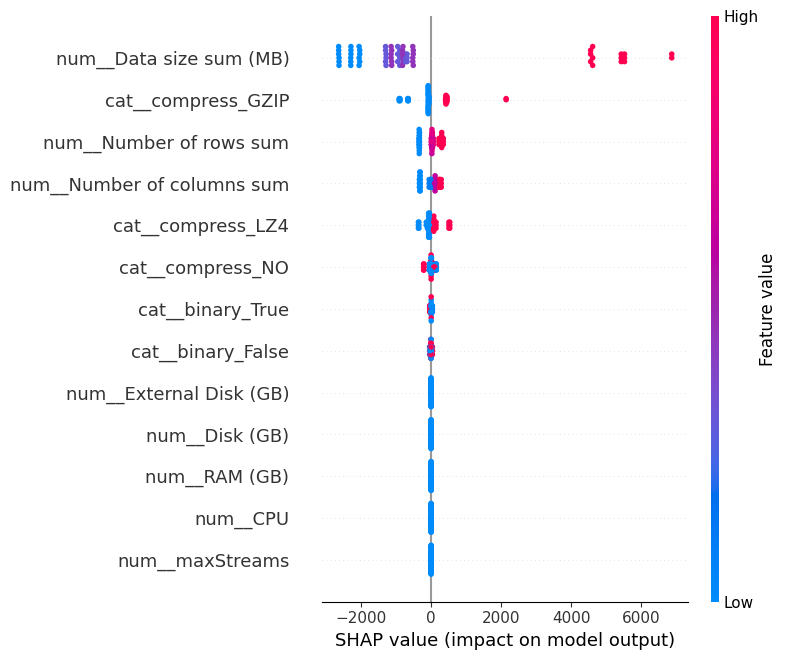

In [52]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer and Compute SHAP Values
def shap_analysis(model, model_name, X):
    """
    Perform SHAP analysis for a given model.
    """
    print(f"\nRunning SHAP Analysis for {model_name} ({type(model).__name__})...\n")
    
    # Initialize the SHAP Explainer
    explainer = shap.Explainer(model, X)
    
    # Compute SHAP values
    shap_values = explainer(X)
    
    # Summary Plot: Global Feature Importance
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X)
    
    return shap_values

# Perform SHAP analysis for the best versions of the top two models
shap_values_1 = shap_analysis(top_model_1, best_model_1, X)
shap_values_2 = shap_analysis(top_model_2, best_model_2, X)
